DL model to classify pokemons by types 

Dataset source: https://www.kaggle.com/datasets/vishalsubbiah/pokemon-images-and-types 

In [20]:
import os
import shutil
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt


from keras.preprocessing.image import ImageDataGenerator
from keras import models
from keras.applications import VGG16 
from keras import layers
from keras import optimizers

import warnings
warnings.filterwarnings('ignore')

In [21]:
#load csv and add filenames
df = pd.read_csv("pokemon.csv")
original_dataset = "images/images/"
filenames = os.listdir(original_dataset)
filenames_dict = {}
for filename in filenames:
	filenames_dict[filename.split(".")[0]] = filename
df = df.assign(Filename=df.Name.map(filenames_dict))

In [22]:
#Get valid types (any that has more than 50 occurrences)
# df.groupby("Type1")["Type1"].count().sort_values(ascending=False)
valid_types = list(df.groupby("Type1")["Type1"].count().loc[lambda x: x > 50].index)
print(f"Valid types: {valid_types}")

Valid types: ['Bug', 'Fire', 'Grass', 'Normal', 'Psychic', 'Water']


In [23]:
#Fitler pokemon by valid types
valid_pokemon = df[df["Type1"].isin(valid_types)];
valid_pokemon = valid_pokemon[["Name", "Type1", "Filename"]]
valid_pokemon.reset_index(inplace=True)
valid_pokemon

,index,Name,Type1,Filename
0,0,bulbasaur,Grass,bulbasaur.png
1,1,ivysaur,Grass,ivysaur.png
2,2,venusaur,Grass,venusaur.png
3,3,charmander,Fire,charmander.png
4,4,charmeleon,Fire,charmeleon.png
...,...,...,...,...
470,793,buzzwole,Bug,buzzwole.jpg
471,794,pheromosa,Bug,pheromosa.jpg
472,797,kartana,Grass,kartana.jpg
473,799,necrozma,Psychic,necrozma.jpg


In [24]:
#Data split
train, validation, test = np.split(valid_pokemon, [int(0.6*len(valid_pokemon)), int(0.8*len(valid_pokemon))])    

In [25]:
#Create directories
base_dir = "pokemon/"
os.makedirs(base_dir, exist_ok=True)

train_dir = os.path.join(base_dir, "train")
os.makedirs(train_dir, exist_ok=True)
validation_dir = os.path.join(base_dir, "validation")
os.makedirs(validation_dir, exist_ok=True)
test_dir = os.path.join(base_dir, "test")
os.makedirs(test_dir, exist_ok=True)

for type in valid_types:
	new_dir = os.path.join(train_dir, type)
	os.makedirs(new_dir, exist_ok=True)

for type in valid_types:
	new_dir = os.path.join(validation_dir, type)
	os.makedirs(new_dir, exist_ok=True)

for type in valid_types:
	new_dir = os.path.join(test_dir, type)
	os.makedirs(new_dir, exist_ok=True)

for index, row in train.iterrows():
	src = os.path.join(original_dataset, row["Filename"])
	folder = os.path.join(train_dir, row["Type1"])
	dst = os.path.join(folder, row["Filename"])
	shutil.copyfile(src, dst)

for index, row in validation.iterrows():
	src = os.path.join(original_dataset, row["Filename"])
	folder = os.path.join(validation_dir, row["Type1"])
	dst = os.path.join(folder, row["Filename"])
	shutil.copyfile(src, dst)

for index, row in test.iterrows():
	src = os.path.join(original_dataset, row["Filename"])
	folder = os.path.join(test_dir, row["Type1"])
	dst = os.path.join(folder, row["Filename"])
	shutil.copyfile(src, dst)


In [26]:
datagen = ImageDataGenerator()
train_generator = datagen.flow_from_directory(train_dir, color_mode='rgb', class_mode="categorical", target_size=(240, 240))
validation_generator = datagen.flow_from_directory(validation_dir, color_mode='rgb', class_mode="categorical", target_size=(240, 240))
test_generator = datagen.flow_from_directory(test_dir, class_mode="categorical", color_mode='rgb', target_size=(240, 240))

Found 285 images belonging to 6 classes.
Found 95 images belonging to 6 classes.
Found 95 images belonging to 6 classes.


In [27]:
model1 = models.Sequential()
model1.add(layers.Conv2D(16, (3,3), activation="relu", input_shape=(240, 240, 3)))
model1.add(layers.MaxPooling2D(5,5))
model1.add(layers.Conv2D(32, (3,3), activation="relu"))
model1.add(layers.Flatten())
model1.add(layers.Dense(32, activation="relu"))
model1.add(layers.Dense(6, activation="softmax"))

model1.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_6 (Conv2D)           (None, 238, 238, 16)      448       
                                                                 
 max_pooling2d_4 (MaxPooling  (None, 47, 47, 16)       0         
 2D)                                                             
                                                                 
 conv2d_7 (Conv2D)           (None, 45, 45, 32)        4640      
                                                                 
 flatten_2 (Flatten)         (None, 64800)             0         
                                                                 
 dense_4 (Dense)             (None, 32)                2073632   
                                                                 
 dense_5 (Dense)             (None, 6)                 198       
                                                      

In [28]:
model1.compile(loss="binary_crossentropy", optimizer="adam", metrics=["acc"])

In [29]:
history1 = model1.fit_generator(train_generator, epochs=20, verbose=2, validation_data=validation_generator)

Epoch 1/20


<ipython-input-29-4efc17763423>:1: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  history1 = model1.fit_generator(train_generator, epochs=20, verbose=2, validation_data=validation_generator)
/usr/lib/python3/dist-packages/PIL/Image.py:931: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(


9/9 - 6s - loss: 11.1137 - acc: 0.2386 - val_loss: 3.8825 - val_acc: 0.2632 - 6s/epoch - 670ms/step
Epoch 2/20
9/9 - 5s - loss: 1.0270 - acc: 0.5298 - val_loss: 1.0300 - val_acc: 0.1789 - 5s/epoch - 565ms/step
Epoch 3/20


KeyboardInterrupt: 

In [ ]:
acc1 = history1.history['acc']
val_acc1 = history1.history['val_acc']
loss1 = history1.history['loss']
val_loss1 = history1.history['val_loss']

In [ ]:
epochs = range(1, len(acc1)+1)

plt.plot(epochs,acc1,'b',label='train accuracy')
plt.plot(epochs,val_acc1, 'r', label='validation accuracy')
plt.title('train acc vs val acc')
plt.legend()

plt.figure()

plt.plot(epochs,loss1, 'b', label ='training loss')
plt.plot(epochs,val_loss1, 'r', label = 'validation loss')
plt.title('train loss vs val loss')
plt.legend()

plt.show()

In [ ]:
test_loss1, test_acc1 = model1.evaluate_generator(test_generator, steps = 5)
test_acc1

In [ ]:
model1.save("model1.h5")

In [ ]:
conv_base = VGG16(weights=None, include_top=False, input_shape=(240, 240, 3))

model2 = models.Sequential()
model2.add(conv_base)
model2.add(layers.Flatten())
model2.add(layers.Dense(64, activation="relu"))
model2.add(layers.Dense(6, activation="softmax"))

conv_base.trainable = False

model2.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 vgg16 (Functional)          (None, 7, 7, 512)         14714688  
                                                                 
 flatten (Flatten)           (None, 25088)             0         
                                                                 
 dense (Dense)               (None, 64)                1605696   
                                                                 
 dense_1 (Dense)             (None, 6)                 390       
                                                                 
Total params: 16,320,774
Trainable params: 1,606,086
Non-trainable params: 14,714,688
_________________________________________________________________


In [ ]:
model2.compile(loss="binary_crossentropy", optimizer="adam", metrics=["acc"])

In [ ]:
history2 = model2.fit_generator(train_generator, epochs=20, verbose=2, validation_data=validation_generator)

<ipython-input-11-da5838df2c86>:1: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  history = model.fit_generator(train_generator, epochs=5, verbose=2, validation_data=validation_generator)
/usr/lib/python3/dist-packages/PIL/Image.py:931: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(


Epoch 1/5
9/9 - 156s - loss: 0.6832 - acc: 0.2000 - val_loss: 0.6103 - val_acc: 0.1789 - 156s/epoch - 17s/step
Epoch 2/5
9/9 - 159s - loss: 0.4984 - acc: 0.2140 - val_loss: 0.5179 - val_acc: 0.2000 - 159s/epoch - 18s/step
Epoch 3/5
9/9 - 131s - loss: 0.4284 - acc: 0.3298 - val_loss: 0.4859 - val_acc: 0.2105 - 131s/epoch - 15s/step
Epoch 4/5
9/9 - 126s - loss: 0.4006 - acc: 0.3614 - val_loss: 0.4741 - val_acc: 0.2316 - 126s/epoch - 14s/step
Epoch 5/5
9/9 - 123s - loss: 0.3860 - acc: 0.4316 - val_loss: 0.5035 - val_acc: 0.2105 - 123s/epoch - 14s/step


In [ ]:
acc2 = history2.history['acc']
val_acc2 = history2.history['val_acc']
loss2 = history2.history['loss']
val_loss2 = history2.history['val_loss']

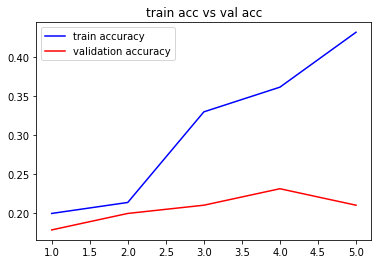

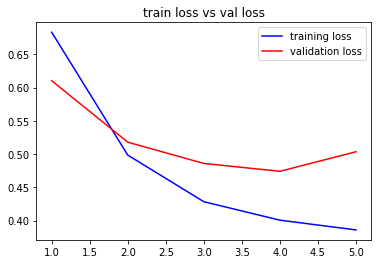

In [ ]:
epochs = range(1, len(acc2)+1)

plt.plot(epochs,acc2,'b',label='train accuracy')
plt.plot(epochs,val_acc2, 'r', label='validation accuracy')
plt.title('train acc vs val acc')
plt.legend()

plt.figure()

plt.plot(epochs,loss2, 'b', label ='training loss')
plt.plot(epochs,val_loss2, 'r', label = 'validation loss')
plt.title('train loss vs val loss')
plt.legend()

plt.show()

In [ ]:
test_loss, test_acc = model2.evaluate_generator(test_generator, steps = 5)
test_acc

<ipython-input-14-0743841271e5>:1: UserWarning: `Model.evaluate_generator` is deprecated and will be removed in a future version. Please use `Model.evaluate`, which supports generators.
  test_loss, test_acc = model.evaluate_generator(test_generator, steps = 5)


0.2210526317358017

In [ ]:
predictions = model2.predict(test_generator)

3/3 [==============================] - 14s 5s/step


In [ ]:
model2.save("model2.h5")

In [ ]:
np.argmax(valid_types[predictions[0]])

NameError: name 'np' is not defined